In [1]:
import iris
import iris.plot as iplt
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/nick/python/ASoP_global/ASoP-Coherence')
from asop_coherence_global_temporal import get_asop_dict
import matplotlib.cm as mpl_cm
import numpy as np
import numpy.ma as ma

In [2]:
def load_summary_metric(filename,constraint,new_long_name,new_units):
    cube = iris.load_cube(filename,constraint)
    cube.long_name = new_long_name
    cube.units = new_units
    return(cube)

In [3]:
def load_all_summary_metrics(asop_dict,wet_season_threshold='1d24'):
    constraints_longnames_units = [
        ('Temporal intermittency on-off metric based on 4 divisions (mean of all months in wet season)','Temporal coherence metric, 4 divs, all wet season, 3hr - '+asop_dict['name'],'1'),
        ('Probability of upper division followed by upper division (mean of all months in wet season)','p(on|on), 4 divs, all wet season, 3hr '+asop_dict['name'],'1'),
        ('Probability of upper division followed by lower division (mean of all months in wet season)','p(on|off), 4 divs, all wet season, 3hr '+asop_dict['name'],'1'),
        ('Probability of lower division followed by upper division (mean of all months in wet season)','p(off|on), 4 divs, all wet season, 3hr '+asop_dict['name'],'1'),
        ('Probability of lower division followed by lower division (mean of all months in wet season)','p(off|off), 4 divs, all wet season, 3hr '+asop_dict['name'],'1')
    ]
    out_cubelist = []
    summary_file = asop_dict['desc']+'_asop_temporal_summary_wetseason'+wet_season_threshold+'.nc'
    for constraint,long_name,units in constraints_longnames_units:
        cube = load_summary_metric(str(asop_dict['dir']/summary_file),constraint,long_name,units)
        out_cubelist.append(cube)
    return(out_cubelist)

In [49]:
def find_autocorr_threshold(cube,lag_length,threshold=0.5,long_name=None,units=None):
    import numpy as np
    #max_autocorr = cube.collapsed('lag',iris.analysis.MEAN).copy()
    lon = cube.coord('longitude')
    lat = cube.coord('latitude')
    nlon = len(lon.points)
    nlat = len(lat.points)
    nlag = len(cube.coord('lag').points)
#    max_autocorr = iris.cube.Cube(np.ma.empty((nlat,nlon)),dim_coords_and_dims=[(lat,0),(lon,1)])
    max_autocorr = np.zeros((nlat,nlon))
    for y in range(nlat):
        for x in range(nlon):
            below_threshold = np.where(cube.data[:,y,x] <= threshold)
            if np.sum(below_threshold) >= 1:
                max_autocorr[y,x] = np.amin(below_threshold)*lag_length+0.5
            else:
                max_autocorr[y,x] = nlag*lag_length+0.5
    max_autocorr_cube = iris.cube.Cube(data=max_autocorr,dim_coords_and_dims=[(lat,0),(lon,1)],long_name=long_name,units=units,var_name='autocorr_threshold'+str(threshold))
    return(max_autocorr_cube) 

In [52]:
def plot_summary_metric(model_cube,obs_cube,model_dict,obs_dict,raw_levs,diff_levs,raw_cmap,diff_cmap):
    fig = plt.figure()
    raw_cmap = mpl_cm.get_cmap(raw_cmap)
    diff_cmap = mpl_cm.get_cmap(diff_cmap)
    qplt.contourf(model_cube,raw_levs,cmap=raw_cmap)
    plt.gca().coastlines()
    plt.savefig('plots/asop_coherence_global_temporal_'+model_dict['name']+'_'+model_cube.var_name+'.png',dpi=200)

    fig = plt.figure()
    qplt.contourf(obs_cube,raw_levs,cmap=raw_cmap)
    plt.gca().coastlines()
    plt.savefig('plots/asop_coherence_global_temporal_'+obs_dict['name']+'_'+obs_cube.var_name+'.png',dpi=200)

    fig = plt.figure()
    diff_cube = model_cube-obs_cube
    diff_cube.long_name=model_cube.long_name+' diff '+obs_dict['name']
    qplt.contourf(diff_cube,diff_levs,cmap=diff_cmap)
    plt.gca().coastlines()
    plt.savefig('plots/asop_coherence_global_temporal_'+model_dict['name']+'-minus-'+obs_dict['name']+'_'+model_cube.var_name+'.png',dpi=200)

In [50]:
awi_dict = get_asop_dict('AWI')
gpm_dict = get_asop_dict('GPM_IMERG')
awi_temporal_summary,awi_ponon,awi_ponoff,awi_poffon,awi_poffoff = load_all_summary_metrics(awi_dict)
gpm_temporal_summary,gpm_ponon,gpm_ponoff,gpm_poffon,gpm_poffoff = load_all_summary_metrics(gpm_dict)

In [65]:
awi_autocorr_filename = str(awi_dict['dir'])+'/'+awi_dict['desc']+'_asop_temporal_autocorr_wetseason1d24.nc'
awi_autocorr = load_summary_metric(awi_autocorr_filename,'autocorr_wetseason_precip_mean',None,'Hours')
gpm_autocorr_filename = str(gpm_dict['dir'])+'/'+gpm_dict['desc']+'_asop_temporal_autocorr_wetseason1d24.nc'
gpm_autocorr = load_summary_metric(gpm_autocorr_filename,'autocorr_wetseason_precip_mean',None,'Hours')



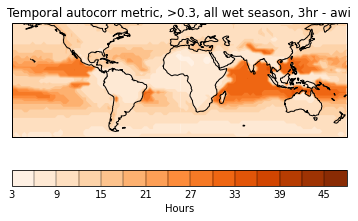

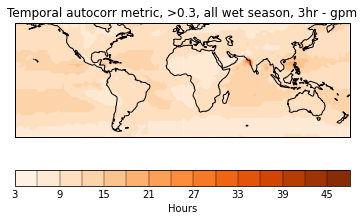

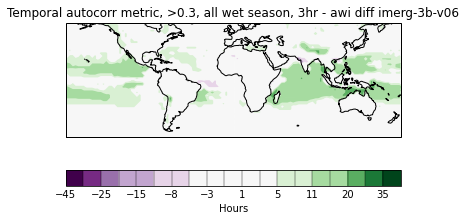

In [66]:
autocorr_threshold=0.2
awi_autocorr_threshold = find_autocorr_threshold(awi_autocorr,3,threshold=autocorr_threshold,long_name='Temporal autocorr metric, >'+str(autocorr_threshold)+', all wet season, 3hr - AWI',units='Hours')
gpm_autocorr_threshold = find_autocorr_threshold(gpm_autocorr,3,threshold=autocorr_threshold,long_name='Temporal autocorr metric, >'+str(autocorr_threshold)+', all wet season, 3hr - GPM',units='Hours')
autocorr_raw_levels=[3,6,9,12,15,18,21,24,27,30,33,36,39,42,45,48]
autocorr_diff_levels=[-45,-35,-25,-20,-15,-11,-8,-5,-3,-1,1,3,5,8,11,15,20,25,35,45]
plot_summary_metric(awi_autocorr_threshold,gpm_autocorr_threshold,awi_dict,gpm_dict,autocorr_raw_levels,autocorr_diff_levels,'Oranges','brewer_PRGn_11')

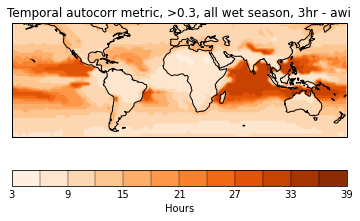

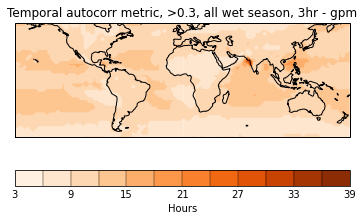

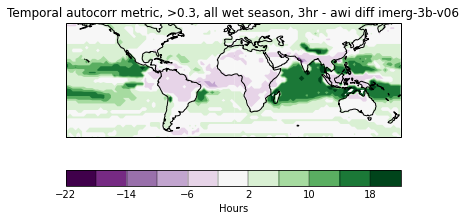

In [68]:
autocorr_threshold=0.3
awi_autocorr_threshold = find_autocorr_threshold(awi_autocorr,3,threshold=autocorr_threshold,long_name='Temporal autocorr metric, >'+str(autocorr_threshold)+', all wet season, 3hr - AWI',units='Hours')
gpm_autocorr_threshold = find_autocorr_threshold(gpm_autocorr,3,threshold=autocorr_threshold,long_name='Temporal autocorr metric, >'+str(autocorr_threshold)+', all wet season, 3hr - GPM',units='Hours')
autocorr_raw_levels=[3,6,9,12,15,18,21,24,27,30,33,36,39] #,42,45,48]
autocorr_diff_levels=[-22,-18,-14,-10,-6,-2,2,6,10,14,18,22]
plot_summary_metric(awi_autocorr_threshold,gpm_autocorr_threshold,awi_dict,gpm_dict,autocorr_raw_levels,autocorr_diff_levels,'Oranges','brewer_PRGn_11')

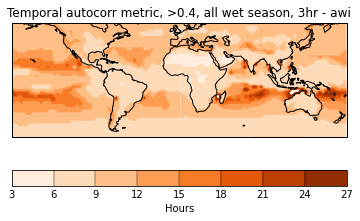

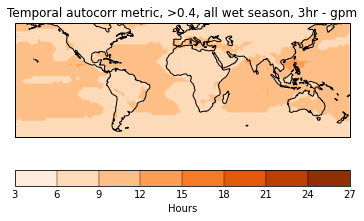

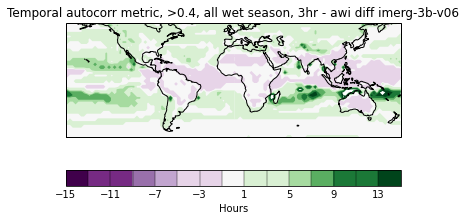

In [72]:
autocorr_threshold=0.5
awi_autocorr_threshold = find_autocorr_threshold(awi_autocorr,3,threshold=autocorr_threshold,long_name='Temporal autocorr metric, >'+str(autocorr_threshold)+', all wet season, 3hr - AWI',units='Hours')
gpm_autocorr_threshold = find_autocorr_threshold(gpm_autocorr,3,threshold=autocorr_threshold,long_name='Temporal autocorr metric, >'+str(autocorr_threshold)+', all wet season, 3hr - GPM',units='Hours')
autocorr_raw_levels=[3,6,9,12,15,18,21,24,27]#,30,33,36,39] #,42,45,48]
autocorr_diff_levels=[-15,-13,-11,-9,-7,-5,-3,-1,1,3,5,7,9,11,13,15]
plot_summary_metric(awi_autocorr_threshold,gpm_autocorr_threshold,awi_dict,gpm_dict,autocorr_raw_levels,autocorr_diff_levels,'Oranges','brewer_PRGn_11')

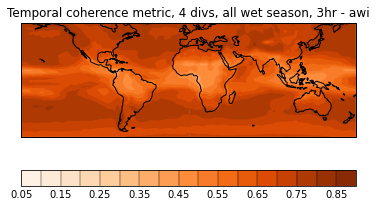

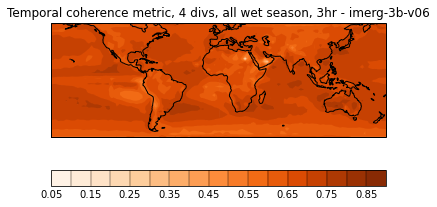

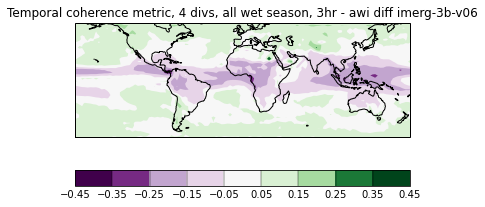

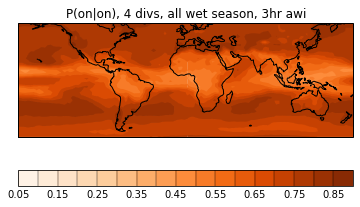

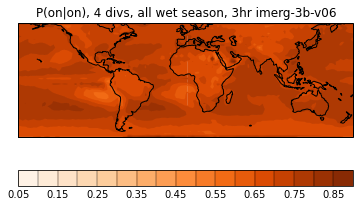

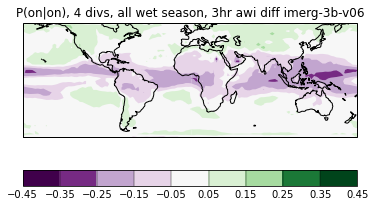

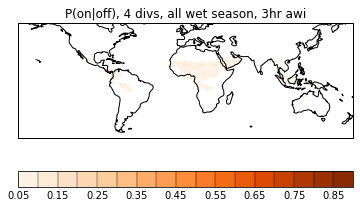

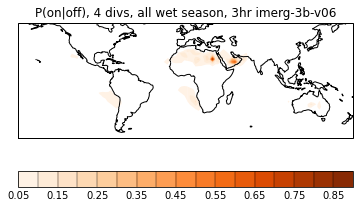

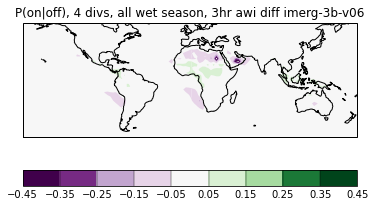

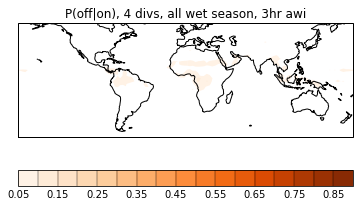

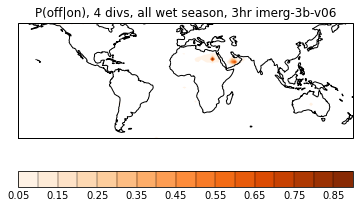

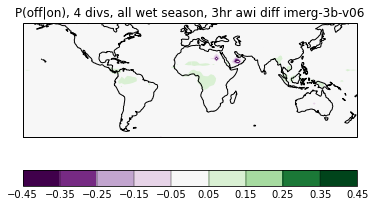

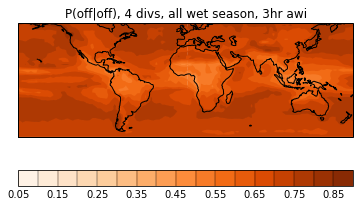

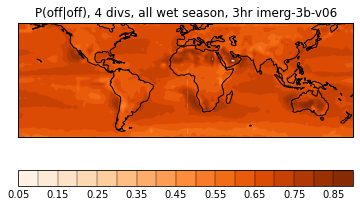

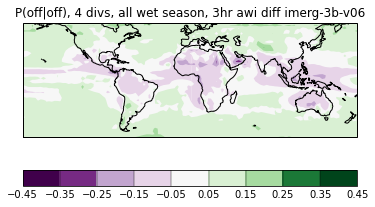

In [54]:
prob_raw_levs=[0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9]
prob_diff_levs=[-0.45,-0.35,-0.25,-0.15,-0.05,0.05,0.15,0.25,0.35,0.45]
plot_summary_metric(awi_temporal_summary,gpm_temporal_summary,awi_dict,gpm_dict,prob_raw_levs,prob_diff_levs,'Oranges','brewer_PRGn_11')
plot_summary_metric(awi_ponon,gpm_ponon,awi_dict,gpm_dict,prob_raw_levs,prob_diff_levs,'Oranges','brewer_PRGn_11')
plot_summary_metric(awi_ponoff,gpm_ponoff,awi_dict,gpm_dict,prob_raw_levs,prob_diff_levs,'Oranges','brewer_PRGn_11')
plot_summary_metric(awi_poffon,gpm_poffon,awi_dict,gpm_dict,prob_raw_levs,prob_diff_levs,'Oranges','brewer_PRGn_11')
plot_summary_metric(awi_poffoff,gpm_poffoff,awi_dict,gpm_dict,prob_raw_levs,prob_diff_levs,'Oranges','brewer_PRGn_11')